# 프로젝트 개요
- 강의명 : 2022년 K-디지털 직업훈련(Training) 사업 - AI데이터플랫폼을 활용한 빅데이터 분석전문가 과정
- 교과목명 : 빅데이터 분석 및 시각화, AI개발 기초, 인공지능 프로그래밍
- 프로젝트 주제 : Ubiquant Market 데이터를 활용한 미래 투자 예측
- 프로젝트 마감일 : 2022년 4월 12일 화요일
- 강사명 : 정지훈 강사
- 수강생명 : 정진우

## < Score Improvement History >
|#|> std * x|k-fold|score|
|:-:|:-:|:-:|:-:|
|1|> std * 70|3|0.1388|
|2|> std * 60|3|0.1387|
|3|> std * 50|3|0.1378|
|4|> std * 40|3|0.1366|
|5|> std * 30|3||
|6|> std * 80|3||
|7|> std * 90|3||

# Step 1 ~ 3 :    
https://www.kaggle.com/code/blackjjw/ubiquant-eda
## dataset :   
https://www.kaggle.com/datasets/blackjjw/ubiquant-train-df-low-memory-pkl

# 라이브러리 불러오기

In [1]:
import numpy as np
import pandas as pd

import gc
import joblib

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as stats

from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgbm
from lightgbm import *

# 데이터 불러오기
- Step 1 ~ 3에서 진행하고 생성한 train_df.pkl를 read.

In [2]:
%%time
train_df = pd.read_pickle('../input/ubiquant-train-df-low-memory-pkl/train_df.pkl')
train_df.head()

CPU times: user 875 ms, sys: 2.4 s, total: 3.27 s
Wall time: 15.6 s


,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300781,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,...,0.365967,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533
1,0_2,0,2,-0.231079,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,...,-0.154175,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506
2,0_6,0,6,0.568848,0.394043,0.615723,0.567871,-0.607910,0.068909,-1.083008,...,-0.138062,0.912598,-0.551758,-1.220703,-1.060547,-0.219116,-1.086914,-0.612305,-0.113953,0.243652
3,0_7,0,7,-1.064453,-2.343750,-0.011871,1.875000,-0.606445,-0.586914,-0.815918,...,0.382080,0.912598,-0.266357,-1.220703,0.941406,-0.608887,0.104919,-0.783203,1.151367,-0.773438
4,0_8,0,8,-0.531738,0.842285,-0.262939,2.330078,-0.583496,-0.618164,-0.742676,...,-0.170410,0.912598,-0.741211,-1.220703,0.941406,-0.588379,0.104919,0.753418,1.345703,-0.737793


# Step 4. 데이터 전처리

## 필요없는 컬럼 제거
- row_id는 단순 행 번호를 나타내므로 제거.
- 컬럼 리스트를 따로 생성하고 'row_id' 제거.
- 'time_id' 제거
- 종속변수인 'target' 제거.
- 필요없는 컬럼이 생성된 리스트를 통해 필요한 컬럼들만 추출하여 사용.

In [3]:
feature_cols = train_df.columns.unique()
feature_cols = feature_cols.drop(['row_id', 'target', 'time_id'])
feature_cols

Index(['investment_id', 'f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7',
       'f_8',
       ...
       'f_290', 'f_291', 'f_292', 'f_293', 'f_294', 'f_295', 'f_296', 'f_297',
       'f_298', 'f_299'],
      dtype='object', length=301)

## 결측치 제거
- dataset 내에 결측치가 존재하지 않음.

## 이상치 제거
- 평균에서 멀리 떨어져 있는 값들을 제거 (> std*num)

## mean > std * x
- 이상치의 개수와 리스트를 반환
|x|outlier count|
|:-----:|:-----:|
|90|21|
|80|42|
|70|128|
|60|325|
|50|788|
|40|2232|
|30|5707|

In [4]:
outlier_list = []
num = 90

for col in feature_cols :
    trans_dtype_df = train_df[col].astype(np.float32)
    
    temp_df = train_df[(trans_dtype_df > trans_dtype_df.mean() + trans_dtype_df.std() * num) |
                       (trans_dtype_df < trans_dtype_df.mean() - trans_dtype_df.std() * num) ]
    if len(temp_df) >0 :
        outliers = temp_df.index.to_list()
        outlier_list.extend(outliers)
        print(col, len(temp_df))
        gc.collect()

outlier_list = list(set(outlier_list))
print(len(outlier_list))
gc.collect()

f_124 15
f_200 6
21


0

- 이상치 제거

In [5]:
train_df.drop(train_df.index[outlier_list], inplace = True)
train_df
gc.collect()

21

# Step 5. 머신러닝 모형 개발

- 독립변수와 종속변수를 구분.

In [6]:
#X = train_df[feature_cols]
#y = train_df['target']

- X, y 데이터 분리

In [7]:
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = False)
#X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

- RAM 확보를 위해 X, y 제거

In [8]:
'''
del X
del y
gc.collect()
'''

'\ndel X\ndel y\ngc.collect()\n'

- LightGBM 클래스를 부른 후 모형을 학습

In [9]:
'''
model = lgbm.LGBMRegressor(
        objective="regression",
        metric="rmse",
        n_estimators=500 )

model.fit(X_train, y_train)
'''

'\nmodel = lgbm.LGBMRegressor(\n        objective="regression",\n        metric="rmse",\n        n_estimators=500 )\n\nmodel.fit(X_train, y_train)\n'

In [10]:
"""
for j in [200, 300, 400, 500, 600]:
        model = lgbm.LGBMRegressor(
            objective="regression",
            metric="rmse",
            n_estimators= j )

        model.fit(X_train, y_train)

        score = model.score(X_train, y_train)
        print(f"n_e:{j}, Training Score : {score}")

        y_pred = model.predict(X_valid)
        mse = mean_squared_error(y_valid, y_pred)
        print(f"n_e:{j},MSE : {mse:.2f}")
"""

'\nfor j in [200, 300, 400, 500, 600]:\n        model = lgbm.LGBMRegressor(\n            objective="regression",\n            metric="rmse",\n            n_estimators= j )\n\n        model.fit(X_train, y_train)\n\n        score = model.score(X_train, y_train)\n        print(f"n_e:{j}, Training Score : {score}")\n\n        y_pred = model.predict(X_valid)\n        mse = mean_squared_error(y_valid, y_pred)\n        print(f"n_e:{j},MSE : {mse:.2f}")\n'

### Training_Score & MSE 계산
|test_size|n_estimators|delete outliers|Training_Score|MSE|delete outliers|Training_Score|MSE|delete outliers|Training_Score|MSE|   
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|                              
|0.2|200|X|0.054069993842590924|0.81|>std\*70|0.05405621833673957(<span style="color:blue">$\downarrow$</span>)|0.81|>std\*60|0.05404028505271219(<span style="color:blue">$\downarrow$</span>)|0.81|
|0.3|200|X|0.05846368663812751|0.83|>std\*70|0.058449805435160984(<span style="color:blue">$\downarrow$</span>)|0.82|>std\*60|||
|0.2|300|X|0.06668339494814646|0.82|>std\*70|0.06660813482520711(<span style="color:blue">$\downarrow$</span>)|0.81|>std\*60|0.06678748573971982(<span style="color:red">$\uparrow$</span>)|0.81|
|0.3|300|X|0.07216780004832235|0.83|>std\*70|0.07194148416323642(<span style="color:blue">$\downarrow$</span>)|0.83|>std\*60|||
|0.2|400|X|0.07730909212135473|0.82|>std\*70|0.0772426438888425(<span style="color:blue">$\downarrow$</span>)|0.82|>std\*60|0.07730612556862904(<span style="color:red">$\uparrow$</span>)|0.82|
|0.3|400|X|0.08363594720433998|0.83|>std\*70|0.08389302333398285(<span style="color:red">$\uparrow$</span>)|0.83|>std\*60|||
|0.2|500|X|0.08671736858043233|0.82|>std\*70|0.08636877075690108(<span style="color:blue">$\downarrow$</span>)|0.82|>std\*60|0.08657127960859345(<span style="color:red">$\uparrow$</span>)|0.82|
|0.3|500|X|0.09377199406580616|0.83|>std\*70|0.0941912571685275(<span style="color:red">$\uparrow$</span>)|0.83|>std\*60|||
|0.2|600|X|0.09585158203024369|0.82|>std\*70|0.09531511104149593(<span style="color:blue">$\downarrow$</span>)|0.82|>std\*60|0.09508766558702908(<span style="color:blue">$\downarrow$</span>)|0.82|
|0.3|600|X|0.10299723306322961|0.83|>std\*70|0.10381084559412301(<span style="color:red">$\uparrow$</span>)|0.83|>std\*60|||
|0.2|700|X|0.10387433272279445|0.82|>std\*70|0.10403926054146928(<span style="color:blue">$\downarrow$</span>)|0.82|>std\*60|X|X|

- 이상치를 제거해도 전반적으로 training score가 항상 오르지 않는다.
- 오히려 떨어지는 것으로 보임

- trianing score, MSE 계산

In [11]:
'''
score = model.score(X_train, y_train)
print(f"Training Score : {score}")

y_pred = model.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)
print(f"MSE : {mse:.2f}")
'''


'\nscore = model.score(X_train, y_train)\nprint(f"Training Score : {score}")\n\ny_pred = model.predict(X_valid)\nmse = mean_squared_error(y_valid, y_pred)\nprint(f"MSE : {mse:.2f}")\n'

- LightGBM의 세부 파라미터 적용
    - 참고 자료를 조사하여 적용

In [12]:
#https://www.kaggle.com/valleyzw/ubiquant-lgbm-baseline
params = {
        'learning_rate':0.1,
        "objective": "regression",
        "metric": "rmse",
        'boosting_type': "gbdt",
        'verbosity': -1,
        'n_jobs': -1, 
        'seed': 21,
        'lambda_l1': 1.1895057699067542, 
        'lambda_l2': 1.9079686837880768e-08, 
        'num_leaves': 112, 
        'subsample':None,
        'feature_fraction': 0.6259927292757151, 
        'bagging_fraction': 0.9782210574588895, 
        'bagging_freq': 1, 
        'n_estimators': 306, 
        'max_depth': 12, 
        'max_bin': 494, 
        'min_data_in_leaf': 366,
        'colsample_bytree': None,
        'subsample_freq': None,
        'min_child_samples': None,
        'reg_lambda': None,
        'reg_alpha': None,
    }
gc.collect()

147

- StratifiedkFold를 통한 교차 검증을 통해 훈련 

In [13]:
seed = 0
folds = 3
models = []

skf = StratifiedKFold(folds, shuffle = True, random_state = seed)

for train_index, test_index in skf.split(train_df, train_df['investment_id']):
    train = train_df.iloc[train_index]
    valid = train_df.iloc[test_index]
    
    lgbm = LGBMRegressor(**params)
    '''
        num_leaves=2 ** np.random.randint(3, 8),
        learning_rate = 10 ** (-np.random.uniform(0.1,2)),
        n_estimators = 500,
        min_child_samples = 1000, 
        subsample=np.random.uniform(0.5,1.0), 
        subsample_freq=1,
        n_jobs= -1,
        tree_method ='gpu_hist' ,
    '''
    
    lgbm.fit(train[feature_cols], train['target'], eval_set = (valid[feature_cols], valid['target']))
    models.append(lgbm)
    gc.collect()
gc.collect()

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  UserWarning,


[1]	valid_0's rmse: 0.920847
[2]	valid_0's rmse: 0.919995
[3]	valid_0's rmse: 0.919279
[4]	valid_0's rmse: 0.918627
[5]	valid_0's rmse: 0.918014
[6]	valid_0's rmse: 0.917481
[7]	valid_0's rmse: 0.917004
[8]	valid_0's rmse: 0.916591
[9]	valid_0's rmse: 0.916213
[10]	valid_0's rmse: 0.915885
[11]	valid_0's rmse: 0.915566
[12]	valid_0's rmse: 0.915292
[13]	valid_0's rmse: 0.914991
[14]	valid_0's rmse: 0.914764
[15]	valid_0's rmse: 0.914553
[16]	valid_0's rmse: 0.914341
[17]	valid_0's rmse: 0.914093
[18]	valid_0's rmse: 0.913905
[19]	valid_0's rmse: 0.913686
[20]	valid_0's rmse: 0.91344
[21]	valid_0's rmse: 0.913267
[22]	valid_0's rmse: 0.913097
[23]	valid_0's rmse: 0.912898
[24]	valid_0's rmse: 0.912741
[25]	valid_0's rmse: 0.912597
[26]	valid_0's rmse: 0.912442
[27]	valid_0's rmse: 0.912302
[28]	valid_0's rmse: 0.912104
[29]	valid_0's rmse: 0.911935
[30]	valid_0's rmse: 0.911785
[31]	valid_0's rmse: 0.911631
[32]	valid_0's rmse: 0.911455
[33]	valid_0's rmse: 0.911345
[34]	valid_0's rmse:

0

- 머신러닝을 통해 나온 결과로 feature 별 중요도 그래프

260

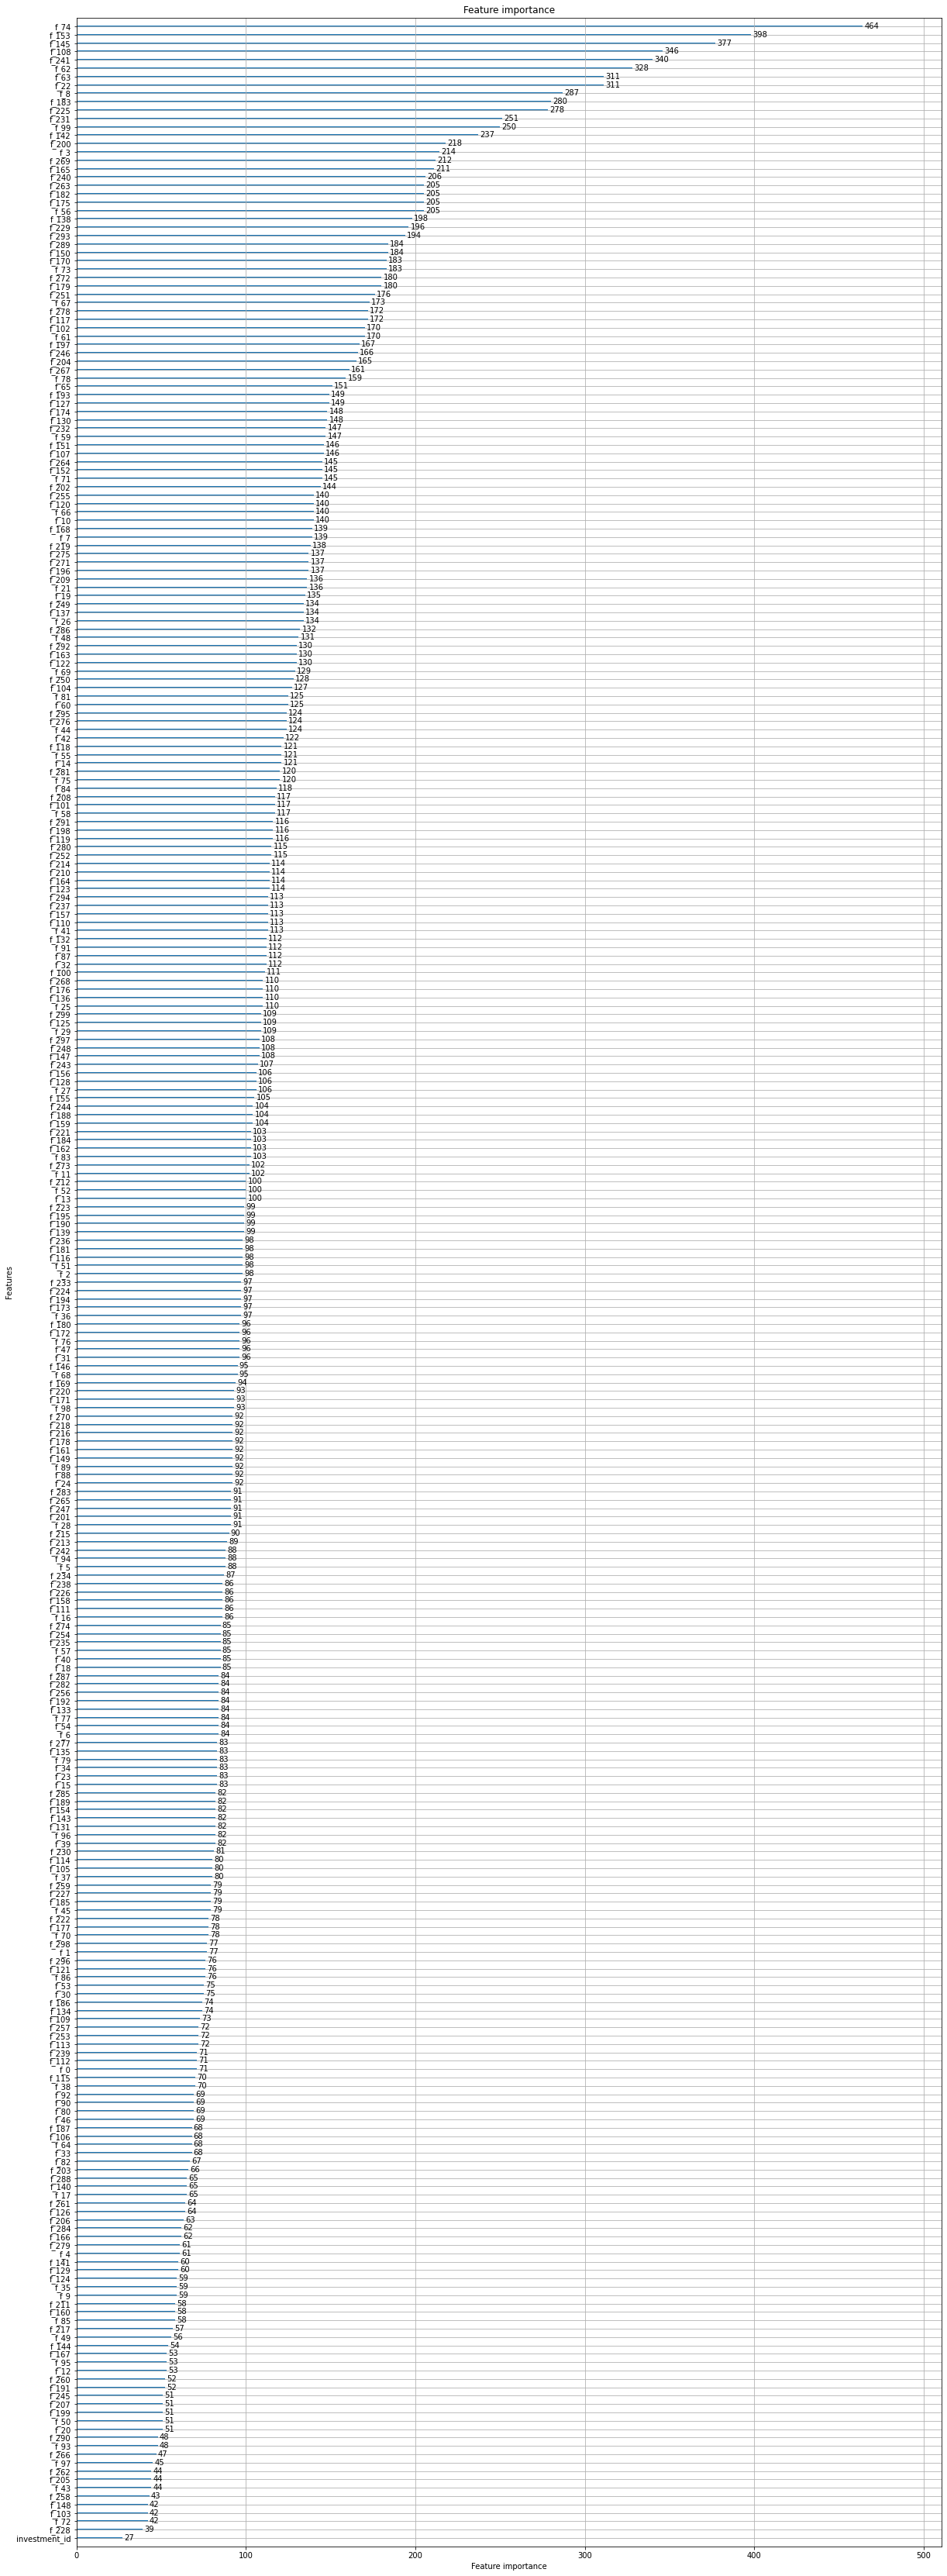

In [14]:
import lightgbm
lightgbm.plot_importance(lgbm, figsize = (20, 60))
gc.collect()

# Step 6. 예측 및 제출

- 주최측에서 제공하는 API를 통해 제출

In [15]:
import ubiquant
env = ubiquant.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test set and sample submission


In [16]:
for (test_df, sample_prediction_df) in iter_test:
    
    test_df['target']  = 0
    
    for lgbm in models:
        test_df['target'] += lgbm.predict(test_df[feature_cols])
    test_df['target'] /= len(models)
    env.predict(test_df[['row_id','target']])

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


# References :    
https://www.kaggle.com/code/yoshikuwano/fast-read-data-and-memory-optimization/notebook   
https://www.kaggle.com/code/rohanrao/tutorial-on-reading-large-datasets/notebook#Format:-csv   
https://www.kaggle.com/code/sytuannguyen/ubiquant-data-preparation#3.-Save-the-reduced-dataframe   
https://www.kaggle.com/code/jnegrini/ubiquant-eda    
https://www.kaggle.com/code/gunesevitan/ubiquant-market-prediction-eda/notebook#3.-Target   
https://www.kaggle.com/code/ilialar/ubiquant-eda-and-baseline#Features    
https://www.kaggle.com/competitions/ubiquant-market-prediction/data    
https://www.kaggle.com/code/larochemf/ubiquant-low-memory-use-be-careful/notebook    
https://www.kaggle.com/code/robikscube/fast-data-loading-and-low-mem-with-parquet-files/notebook    
https://www.kaggle.com/code/lucamassaron/eda-target-analysis       
https://www.kaggle.com/code/edwardcrookenden/eda-and-lgbm-baseline-feature-imp    
https://www.kaggle.com/competitions/ubiquant-market-prediction/discussion/305031    
https://www.kaggle.com/code/junjitakeshima/ubiquant-simple-lgbm-removing-outliers-en-jp/notebook#(1)-Read-Trainiing-Data    
https://www.kaggle.com/code/valleyzw/ubiquant-lgbm-baseline/notebook#Stock-market-calendar-analysis:-discussion     
https://www.kaggle.com/code/sytuannguyen/ubiquant-with-lightgbm   
https://www.kaggle.com/code/jiprud/simple-light-gbm   
https://www.kaggle.com/code/ilialar/ubiquant-eda-and-baseline#Model-training